In [14]:
% load_ext autoreload
% autoreload 2

In [56]:
import numpy as np
import lightkurve as lk
import threemultis
import matplotlib.pyplot as plt

In [57]:
tpf = lk.search_targetpixelfile('K2-43').download()
tpf = tpf[tpf.to_lightcurve().normalize().flux > 0.8]
mask = threemultis.utils.planet_mask(tpf.time, 'K2-43')
aper = tpf.create_threshold_mask(3)

In [60]:
# First pass, remove some very bad outliers
bad = np.zeros(len(tpf.time), bool)
for count in range(3):
    pld_lc = tpf[~bad].to_corrector('pld').correct(aperture_mask=aper, cadence_mask=mask[~bad])
    pld_lc = pld_lc.flatten(31, mask=~mask[~bad])
    bad |= np.in1d(tpf.time, pld_lc.time[np.abs(pld_lc.flux - 1) > 5 * np.std(pld_lc.flux - 1)])
    
tpf = tpf[~bad]
mask = mask[~bad]

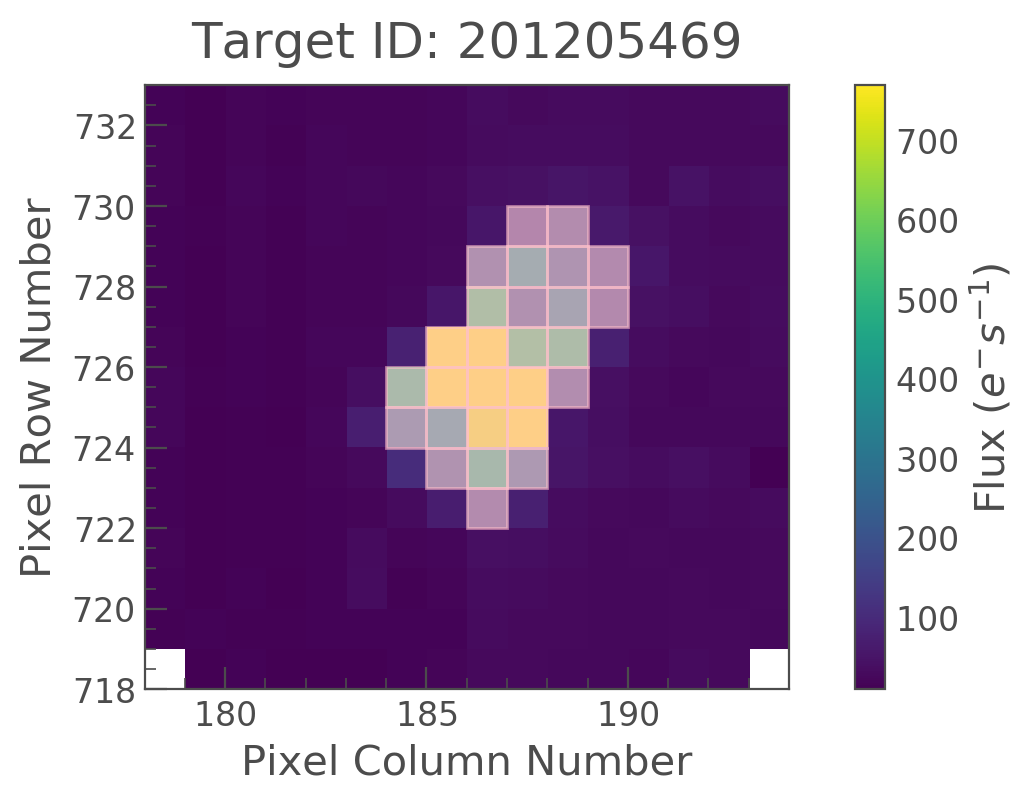

In [61]:
tpf.plot(aperture_mask=aper)

In [81]:
params = threemultis.utils.get_params('K2-43')

/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1172: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/Users/ch/miniconda3/lib/python3.6/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.083742e-17
  rval = scipy.linalg.solve(A, b)
/Users/ch/miniconda3/lib/python3.6/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.083742e-17
  rval = scipy.linalg.solve(A, b)


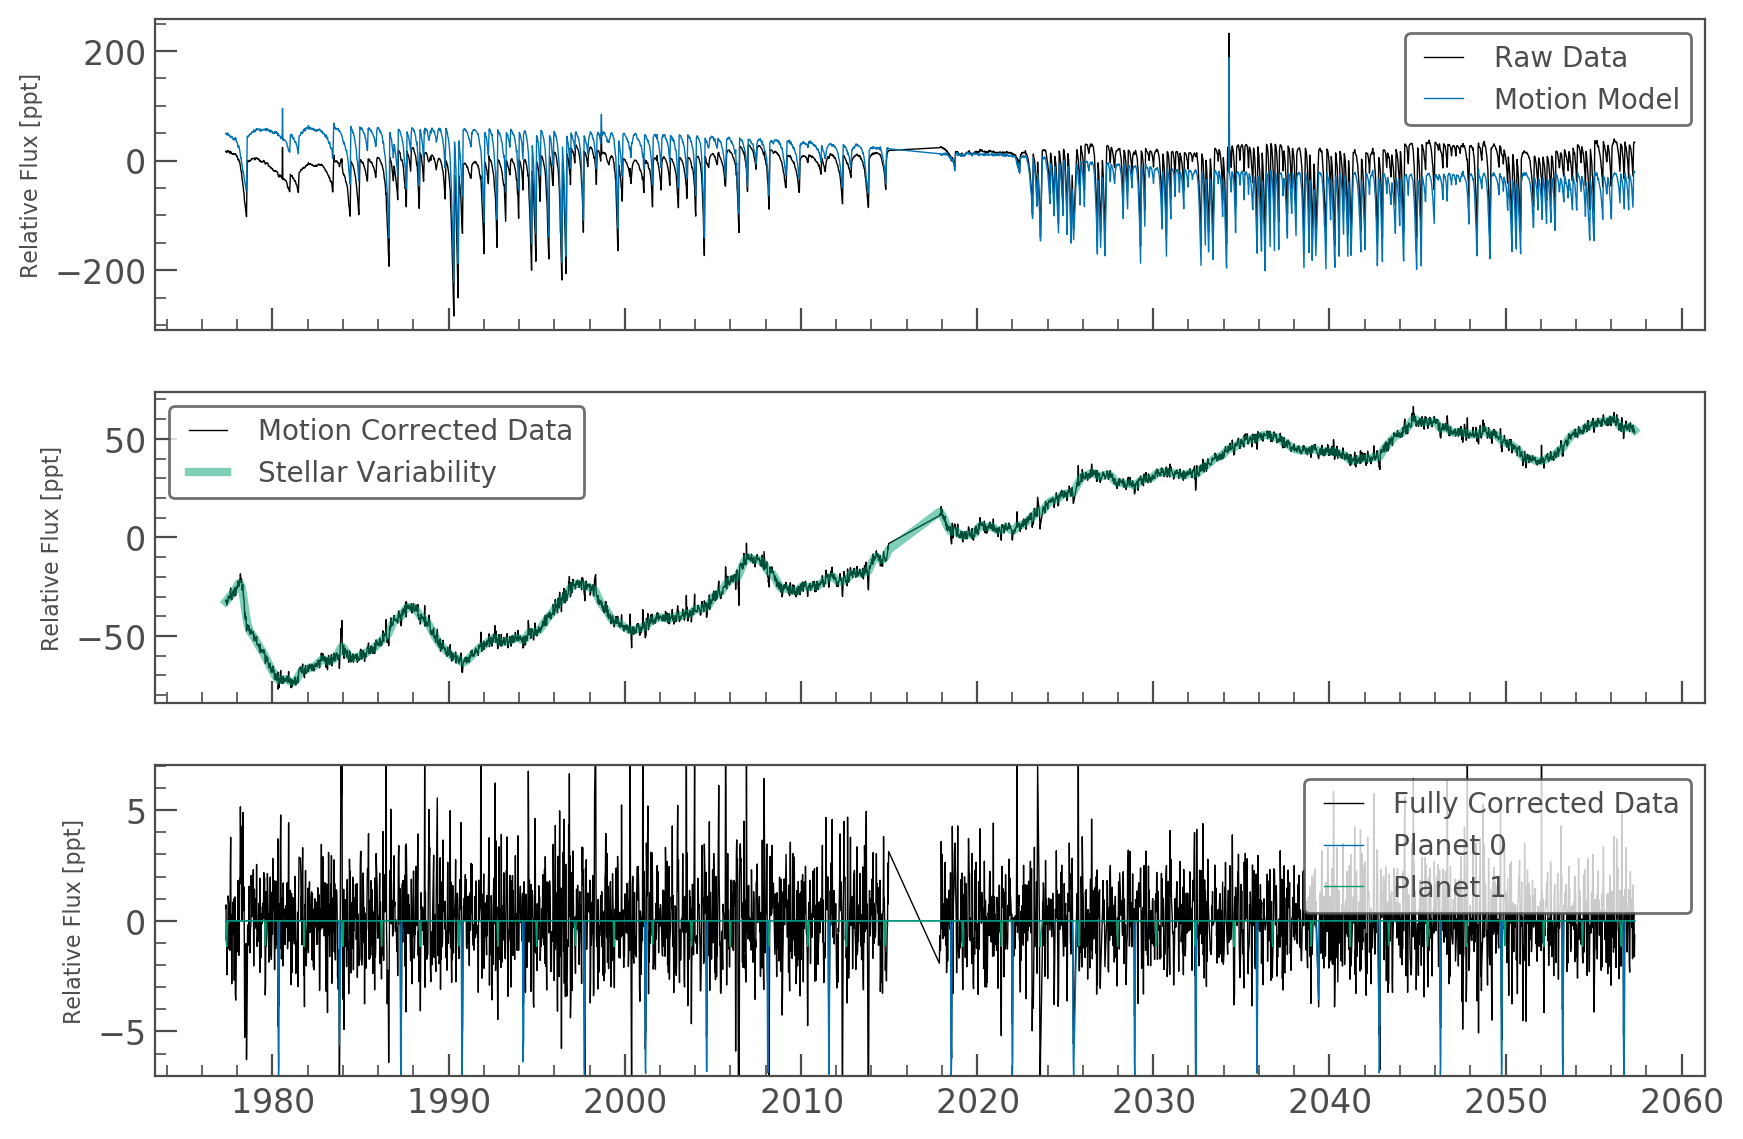

In [82]:
clc = threemultis.fit.joint_fit(tpf, period_value=list(params['Period']),
                                            t0_value=list(params['T0']), depth_value=list(params['Depth']),
                                            duration_value=list(params['T0']),
                                            R_star=(params.loc[0, 'R_star'], params.loc[0, 'R_star_error']),
                                            M_star=(params.loc[0, 'M_star'], params.loc[0, 'M_star_error']),
                                            T_star=(params.loc[0, 'T_star'], params.loc[0, 'T_star_error']),
                                           aperture=aper, return_quick_corrected=True)

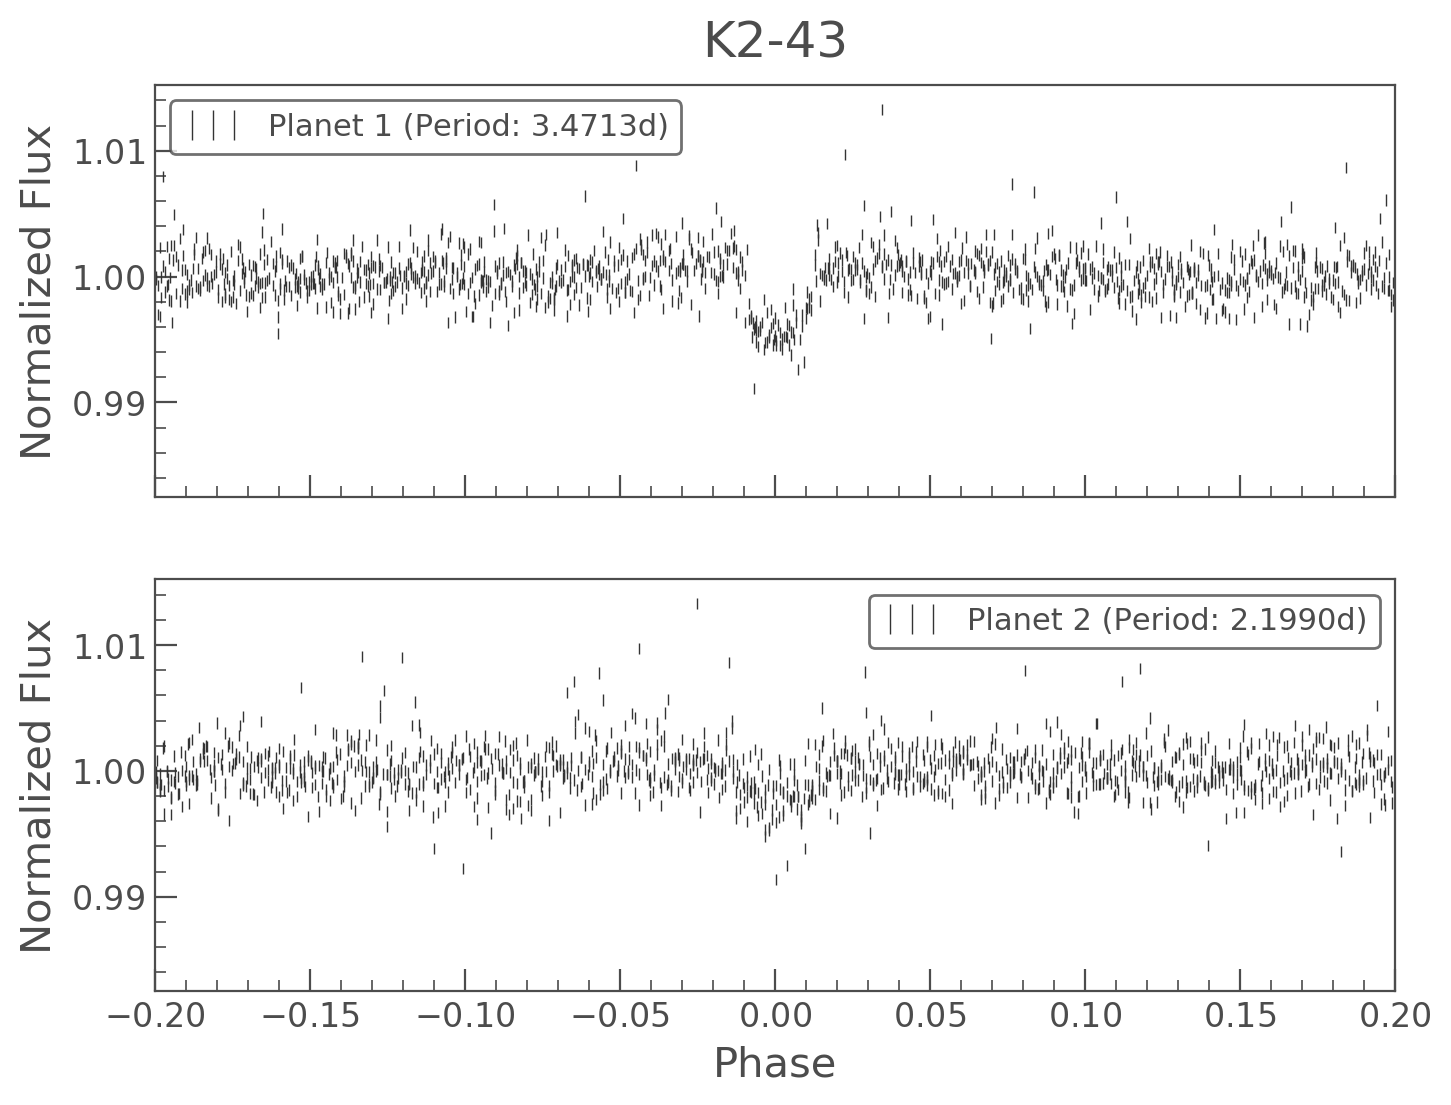

In [83]:
threemultis.utils.planet_plot(clc, 'K2-43');